In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
file_path = '/content/drive/My Drive/gpt-4.csv'
print(os.path.exists(file_path))

True


In [3]:
df=pd.read_csv(file_path, on_bad_lines='skip', nrows=3000)

In [4]:
df.head()

,data,conversation
0,This 60-year-old male was hospitalized due to ...,"Doctor: Good morning, how are you feeling toda..."
1,A 39-year-old man was hospitalized due to an i...,"Doctor: Hello, how are you feeling today?\nPat..."
2,One week after a positive COVID-19 result this...,"Doctor: Hello, how are you feeling today?\nPat..."
3,This 69-year-old male was admitted to the ICU ...,"Doctor: Hello, how are you feeling today?\nPat..."
4,This 57-year-old male was admitted to the ICU ...,"Doctor: Good morning, how are you feeling toda..."


In [5]:
sample = df.sample(n=1000, random_state=42)
sample

,data,conversation
1801,The third case was a 64-year-old female who ad...,"Doctor: Good afternoon, how are you feeling to..."
1190,A 34-year-old woman presented with severe epis...,"Doctor: Good morning, how can I help you today..."
1817,"A 53-year-old man, who had non-exertional ches...","Doctor: Hello, Mr. Johnson. How are you feelin..."
251,"A 34 year old woman from the east of Morocco, ...","Doctor: Good afternoon, Mrs. X. I see here in ..."
2505,A 19-year-old male of Caucasian origin was adm...,"Doctor: Hello, how are you feeling today?\nPat..."
...,...,...
618,A ten-year-old neutered female Cavalier King C...,"Doctor: Hello, how are you today?\nPatient: I'..."
406,A 65-year-old man with continuous irritable co...,"Doctor: Good morning, Mr. Johnson. How are you..."
1157,A 55-year-old woman without relevant medical h...,"Doctor: Hi, how are you feeling today?\nPatien..."
1068,A 52-year-old man was first diagnosed with HIV...,"Doctor: Hi there, how are you feeling today?\n..."


In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nlp=spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

def tokenize_text(text):
  """Tokenize text"""
  return word_tokenize(text)

def stopword_removal(tokens):
  """Removing stop words"""
  stop_words = set(stopwords.words('english'))
  return [word for word in tokens if word not in stop_words]

def lemma_text(tokens):
  """lemmatize tokens"""
  doc = nlp(" ".join(tokens))
  return [token.lemma_ for token in doc if token.lemma_ != "-PRON-"]

def preprocess_text(text):
  text = clean_text(text)
  tokens = tokenize_text(text)
  tokens = stopword_removal(tokens)
  tokens = lemma_text(tokens)
  return " ".join(tokens)

sample['preprossed_text'] = ""
sample['preprossed_text'] = sample['conversation'].astype(str).apply(preprocess_text)

In [8]:
import warnings

warnings.filterwarnings('ignore')
# Calculating term frequencies in previous data where text is not preprocessed

tf_data = sample["data"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf_data.columns = ["words", "tf"]
tf_data.sort_values("tf", ascending=False)

,words,tf
2,the,11490.0
0,and,9770.0
40,of,9012.0
1,was,7648.0
44,a,5200.0
...,...,...
17651,disease.\nThe,1.0
17649,"mind,",1.0
17648,inlet,1.0
17647,glottic,1.0


In [9]:
# Calculating term frequencies for preprocessed text

tf_convo = sample["preprossed_text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf_convo.columns = ["words", "tf"]
tf_convo.sort_values("tf", ascending=False)

,words,tf
33,yes,2870.0
75,see,2337.0
16,okay,2289.0
36,doctor,2054.0
7,s,1863.0
...,...,...
9155,corddoctor,1.0
9154,paratonicdoctor,1.0
9153,craniospinal,1.0
9152,mildtomoderate,1.0


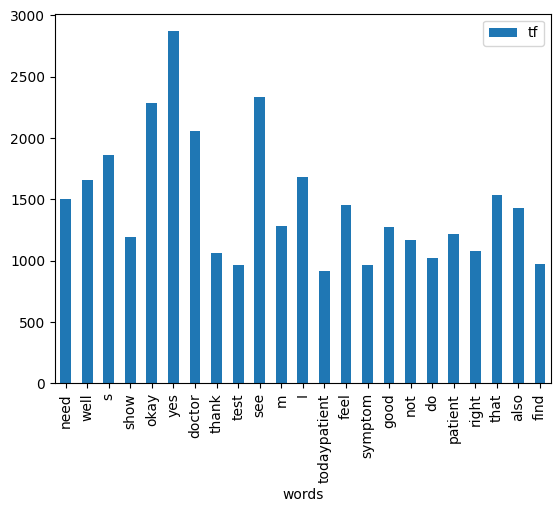

In [10]:
# Barplot for conversation. Shows most repeated words and their count
import matplotlib.pyplot as plt
tf_convo[tf_convo["tf"] > 900].plot.bar(x="words", y="tf")
plt.show()

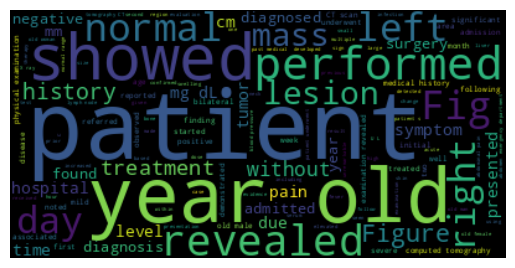

In [11]:
from wordcloud import WordCloud
# Wordcloud for data

text_data = " ".join(i for i in sample.data)

wordcloud = WordCloud().generate(text_data)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

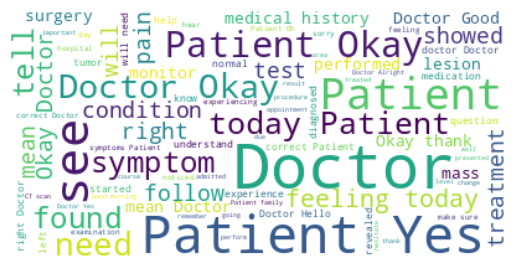

In [12]:
# Wordcloud for conversation

text_convo = " ".join(i for i in sample.conversation)

wordcloud_convo = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text_convo)
plt.figure()
plt.imshow(wordcloud_convo, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
# seperating doctor patient dialogue from conversation so that we can analyze sentiment for doctor and patient

def seperate_convo(conversation):
  doctor_dia = []
  patient_dia =[]

  lines = conversation.split("\n")

  for line in lines:
    if line.startswith("Doctor:"):
      doctor_dia.append(line[len("Doctor:"):].strip())
    elif line.startswith("Patient:"):
      patient_dia.append(line[len("Patient:"):].strip())

  return " ".join(doctor_dia), " ".join(patient_dia)

sample[['doctor_conversation','patient_conversation']]=sample['conversation'].apply(lambda x: pd.Series(seperate_convo(x)))

In [14]:
sample.head()

,data,conversation,preprossed_text,doctor_conversation,patient_conversation
1801,The third case was a 64-year-old female who ad...,"Doctor: Good afternoon, how are you feeling to...",doctor good afternoon feel todaypatient hmm gr...,"Good afternoon, how are you feeling today? Oka...","Hmm, not great actually. I'm having some chest..."
1190,A 34-year-old woman presented with severe epis...,"Doctor: Good morning, how can I help you today...",doctor good morning help todaypatient hi exper...,"Good morning, how can I help you today? When d...","Hi, I have been experiencing severe headaches ..."
1817,"A 53-year-old man, who had non-exertional ches...","Doctor: Hello, Mr. Johnson. How are you feelin...",doctor hello mr johnson feel todaypatient I m ...,"Hello, Mr. Johnson. How are you feeling today?...","I'm feeling okay, doctor. Yes, that's right. N..."
251,"A 34 year old woman from the east of Morocco, ...","Doctor: Good afternoon, Mrs. X. I see here in ...",doctor good afternoon mrs x see medical record...,"Good afternoon, Mrs. X. I see here in your med...","Yes, doctor. That's right. Okay. Oh no. What d..."
2505,A 19-year-old male of Caucasian origin was adm...,"Doctor: Hello, how are you feeling today?\nPat...",doctor hello feel todaypatient I m alright tha...,"Hello, how are you feeling today? I see here t...","I'm doing alright, thank you. Yeah, I was in a..."


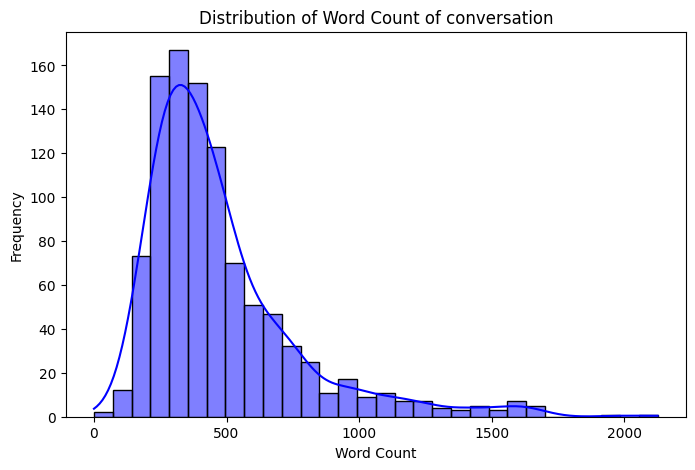

,patient_conversation,word_count
1801,"Hmm, not great actually. I'm having some chest...",228
1190,"Hi, I have been experiencing severe headaches ...",369
1817,"I'm feeling okay, doctor. Yes, that's right. N...",135
251,"Yes, doctor. That's right. Okay. Oh no. What d...",113
2505,"I'm doing alright, thank you. Yeah, I was in a...",428


In [15]:
import seaborn as sns

sample['word_count'] = sample['patient_conversation'].apply(len)

# Plot the distribution of word count
plt.figure(figsize=(8, 5))
sns.histplot(sample['word_count'], kde=True, color='blue', bins=30)
plt.title("Distribution of Word Count of conversation")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

sample[['patient_conversation', 'word_count']].head()

In [16]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [17]:
sample["polarity_doctor_convo"] = sample["doctor_conversation"].apply(lambda x: sia.polarity_scores(x)["compound"])
sample["polarity_doctor_convo"]

,polarity_doctor_convo
1801,-0.9159
1190,-0.4689
1817,0.8205
251,0.8301
2505,0.8053
...,...
618,0.7998
406,-0.4039
1157,-0.8843
1068,-0.2982


In [18]:
sample["polarity_patient_convo"] = sample["patient_conversation"].apply(lambda x: sia.polarity_scores(x)["compound"])
sample["polarity_patient_convo"]

,polarity_patient_convo
1801,-0.5603
1190,-0.3430
1817,0.6369
251,0.8271
2505,-0.9304
...,...
618,0.9400
406,0.9703
1157,-0.1531
1068,-0.2171


In [19]:
sample["sentiment_label_patient"] = sample["patient_conversation"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [20]:
sample["sentiment_label_patient"].value_counts()

,count
sentiment_label_patient,
pos,673
neg,327


In [21]:
sample["sentiment_label_doctor"] = sample["doctor_conversation"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

sample.columns

Index(['data', 'conversation', 'preprossed_text', 'doctor_conversation',
       'patient_conversation', 'word_count', 'polarity_doctor_convo',
       'polarity_patient_convo', 'sentiment_label_patient',
       'sentiment_label_doctor'],
      dtype='object')

In [22]:
sample[[ 'polarity_patient_convo', 'polarity_doctor_convo',
    'sentiment_label_doctor', 'sentiment_label_patient']]

,polarity_patient_convo,polarity_doctor_convo,sentiment_label_doctor,sentiment_label_patient
1801,-0.5603,-0.9159,neg,neg
1190,-0.3430,-0.4689,neg,neg
1817,0.6369,0.8205,pos,pos
251,0.8271,0.8301,pos,pos
2505,-0.9304,0.8053,pos,neg
...,...,...,...,...
618,0.9400,0.7998,pos,pos
406,0.9703,-0.4039,neg,pos
1157,-0.1531,-0.8843,neg,neg
1068,-0.2171,-0.2982,neg,neg


In [23]:
sample["sentiment_label_patient"].value_counts()

,count
sentiment_label_patient,
pos,673
neg,327


In [24]:
sample["sentiment_label_doctor"].value_counts()

,count
sentiment_label_doctor,
pos,682
neg,318


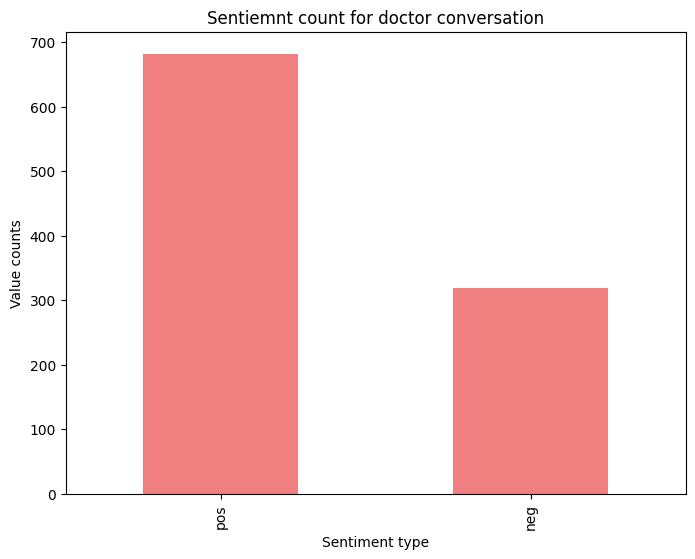

In [25]:
plt.figure(figsize=(8,6))
sample['sentiment_label_doctor'].value_counts().plot(kind='bar', color='lightcoral')
plt.title("Sentiemnt count for doctor conversation")
plt.xlabel("Sentiment type")
plt.ylabel("Value counts")
plt.show()


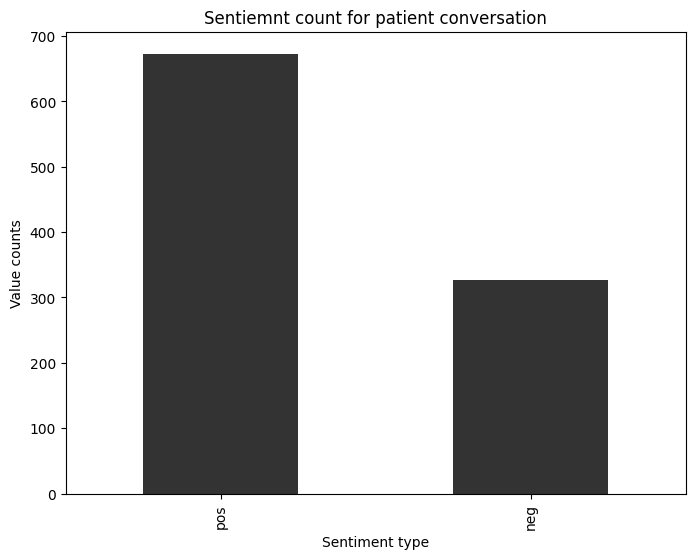

In [26]:
plt.figure(figsize=(8,6))
sample['sentiment_label_patient'].value_counts().plot(kind='bar', color='#333')
plt.title("Sentiemnt count for patient conversation")
plt.xlabel("Sentiment type")
plt.ylabel("Value counts")
plt.show()


In [27]:
def extract_gender(text):
    if re.search(r'\b(she|her|female|woman|girl|miss)\b', text, re.IGNORECASE):
        return 'Female'
    # Look for male-related keywords
    elif re.search(r'\b(he|his|male|man|boy|mr)\b', text, re.IGNORECASE):
        return 'Male'
    return 'Unknown'
sample['gender'] = sample['data'].apply(extract_gender)
print(sample[['data', 'gender']].head())

                                                   data  gender
1801  The third case was a 64-year-old female who ad...  Female
1190  A 34-year-old woman presented with severe epis...  Female
1817  A 53-year-old man, who had non-exertional ches...    Male
251   A 34 year old woman from the east of Morocco, ...  Female
2505  A 19-year-old male of Caucasian origin was adm...    Male


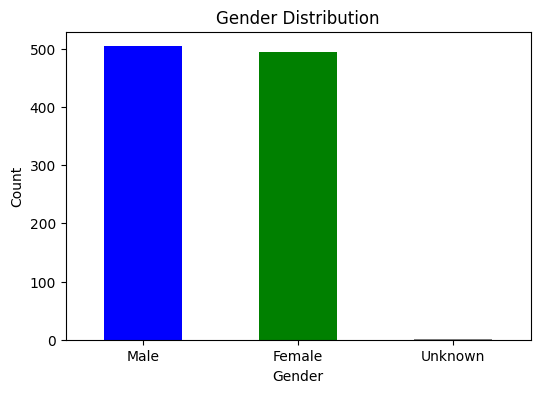

In [28]:
gender_counts = sample['gender'].value_counts()
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['blue', 'green', 'gray'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [29]:
def extract_age(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    match = re.search(r'(\d+)\s*year', text, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return None
sample['age'] = sample['data'].apply(extract_age)

print(sample[['data', 'age']].head())

                                                   data   age
1801  The third case was a 64-year-old female who ad...  64.0
1190  A 34-year-old woman presented with severe epis...  34.0
1817  A 53-year-old man, who had non-exertional ches...  53.0
251   A 34 year old woman from the east of Morocco, ...  34.0
2505  A 19-year-old male of Caucasian origin was adm...  19.0


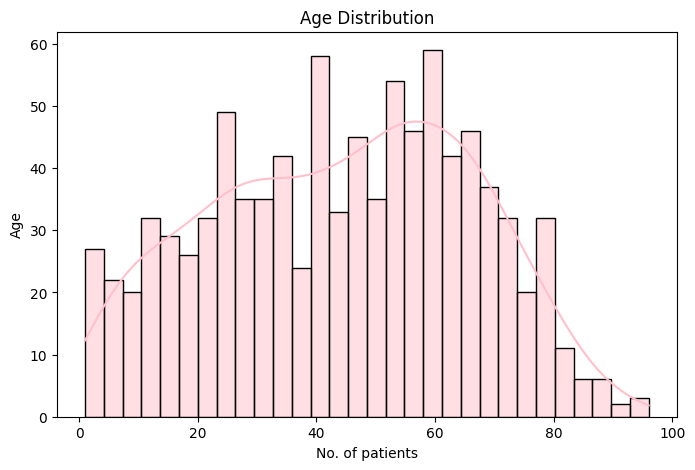

In [30]:
#age distribution graph
plt.figure(figsize=(8, 5))
sns.histplot(sample['age'], kde=True, color='pink', bins=30)
plt.title("Age Distribution")
plt.xlabel("No. of patients")
plt.ylabel("Age")
plt.show()

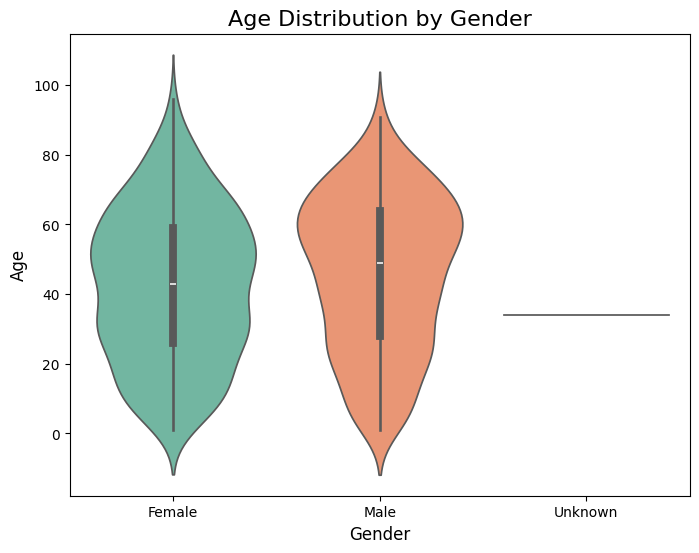

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.violinplot(x='gender', y='age', data=sample, palette="Set2")

plt.title("Age Distribution by Gender", fontsize=16)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Age", fontsize=12)

plt.show();

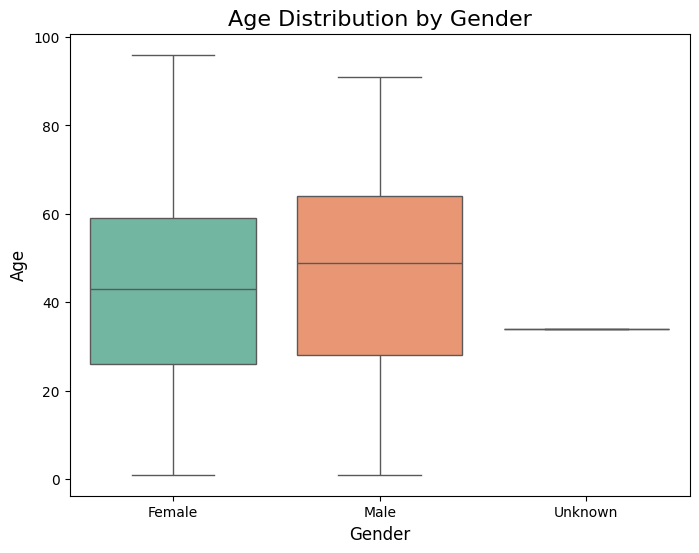

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(x='gender', y='age', data=sample, palette="Set2")

plt.title("Age Distribution by Gender", fontsize=16)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Age", fontsize=12)

plt.show()


In [33]:
from collections import Counter
import re

# Sample of common disease names for extraction (extendable)
common_diseases = [
    'diabetes', 'cancer','asthma', 'stroke', 'malaria', 'arthritis', 'hepatitis',
    'measles', 'mumps', 'rubella', 'pertussis', 'diphtheria', 'polio',
    'Ebola', 'Zika virus', 'yellow fever', 'encephalitis','influenza',
    'herniated disc', 'sciatica', 'Bell’s palsy', 'Guillain-Barre syndrome',
    'pneumonia', 'Parkinson', 'dengue', 'cholera', 'encephalitis', 'lyme disease',
    'epilepsy', 'leukemia', 'depression', 'anxiety', 'migraine', 'eczema',
    'osteoporosis', 'anemia', 'gout', 'obesity', 'cirrhosis', 'bronchitis',
    'lymphoma', 'psoriasis', 'meningitis', 'sinusitis', 'fibromyalgia',
    'tinnitus', 'vertigo', 'vitiligo', 'scabies', 'ringworm',
    'sclerosis', 'ulcer', 'glaucoma', 'sepsis', 'schizophrenia', 'bipolar disorder',
    'autism', 'Down syndrome', 'lupus', 'sarcoidosis', 'tetanus', 'rabies','smallpox',
    'conjunctivitis', 'keratitis', 'otitis', 'colitis', 'IBS', 'Celiac disease',
    'Crohn’s disease', 'diverticulitis', 'pancreatitis', 'renal failure',
    'urinary tract infection', 'prostatitis', 'endometriosis', 'fibroid',
    'cystitis', 'infertility', 'ovarian cyst', 'PCOS', 'impetigo',
    'cellulitis', 'gangrene', 'necrosis', 'alopecia', 'sickle cell anemia',
    'myasthenia gravis', 'dystonia', 'sleep apnea', 'hemorrhoids',
    'thalassemia', 'hemophilia', 'varicose veins',
    'carpal tunnel syndrome', 'tendinitis', 'plantar fasciitis',
    'myasthenia gravis', 'dystonia', 'sleep apnea'
]


In [34]:
def extract_diseases(text, disease_list):
    found_diseases = []
    for disease in disease_list:
        if re.search(rf'\b{re.escape(disease)}\b', text, re.IGNORECASE):
            found_diseases.append(disease)
    return found_diseases

sample['extracted_diseases'] = sample['patient_conversation'].apply(lambda x: extract_diseases(str(x), common_diseases))

all_diseases = [disease for diseases in sample['extracted_diseases'] for disease in diseases]
disease_counts = Counter(all_diseases)
top_20_diseases = disease_counts.most_common(20)
print("Common Diseases:")
for disease, count in top_20_diseases:
    print(f"{disease}: {count} occurrences")

Common Diseases:
diabetes: 39 occurrences
cancer: 27 occurrences
anemia: 10 occurrences
pneumonia: 10 occurrences
sleep apnea: 10 occurrences
ulcer: 8 occurrences
depression: 5 occurrences
colitis: 5 occurrences
cirrhosis: 5 occurrences
lymphoma: 4 occurrences
anxiety: 4 occurrences
obesity: 4 occurrences
arthritis: 4 occurrences
schizophrenia: 4 occurrences
hepatitis: 4 occurrences
necrosis: 4 occurrences
pancreatitis: 4 occurrences
sarcoidosis: 3 occurrences
vertigo: 3 occurrences
bronchitis: 3 occurrences


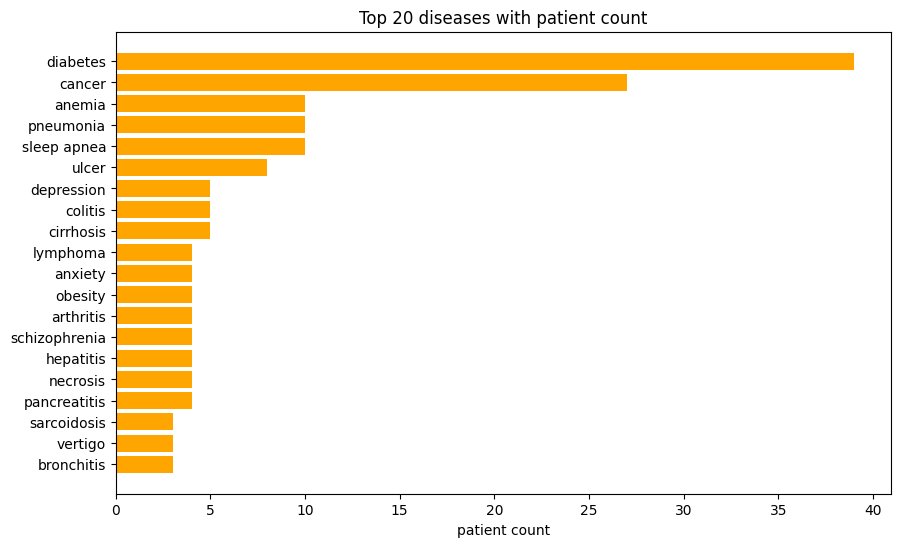

In [35]:
disease_names = [disease for disease, _ in top_20_diseases]
disease_frequencies = [count for _, count in top_20_diseases]


plt.figure(figsize=(10, 6))
plt.barh(disease_names, disease_frequencies, color='orange')
plt.xlabel('patient count')
plt.title('Top 20 diseases with patient count')
plt.gca().invert_yaxis()
plt.show()

In [36]:
pip install dash pandas plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [37]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from dash.dependencies import Input, Output


df = sample

df['extracted_diseases'] = df['extracted_diseases'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the dashboard
app.layout = html.Div([
    html.H1("Doctor-Patient Conversation Dashboard", style={"text-align": "center"}),

    # Row 1: Gender distribution and sentiment count
    html.Div([
        html.Div([
            dcc.Graph(id='gender-distribution'),
        ], className='six columns'),
        html.Div([
            dcc.Graph(id='sentiment-distribution'),
        ], className='six columns'),
    ], className='row'),

    # Row 2: Age distribution and disease occurrences
    html.Div([
        html.Div([
            dcc.Graph(id='age-distribution'),
        ], className='six columns'),
        html.Div([
            dcc.Graph(id='disease-occurrence'),
        ], className='six columns'),
    ], className='row'),
])

# Callbacks for updating the graphs

# Gender distribution pie chart
@app.callback(
    Output('gender-distribution', 'figure'),
    [Input('gender-distribution', 'id')]
)
def update_gender_distribution(_):
    gender_counts = df['gender'].value_counts()
    gender_fig = px.pie(gender_counts, names=gender_counts.index, values=gender_counts.values, title="Gender Distribution")
    return gender_fig

# Sentiment distribution bar chart
@app.callback(
    Output('sentiment-distribution', 'figure'),
    [Input('sentiment-distribution', 'id')]
)
def update_sentiment_distribution(_):
    sentiment_counts = df['sentiment_label_patient'].value_counts()
    sentiment_fig = px.bar(sentiment_counts, x=sentiment_counts.index, y=sentiment_counts.values, title="Sentiment Distribution")
    return sentiment_fig

# Age distribution histogram
@app.callback(
    Output('age-distribution', 'figure'),
    [Input('age-distribution', 'id')]
)
def update_age_distribution(_):
    age_fig = px.histogram(df, x="age", title="Age Distribution", nbins=10)
    return age_fig

# Disease occurrences bar chart (Top 20 Common Diseases)
@app.callback(
    Output('disease-occurrence', 'figure'),
    [Input('disease-occurrence', 'id')]
)
def update_disease_occurrence(_):
    # Flatten the list of extracted diseases and count occurrences
    all_diseases = [disease for sublist in df['extracted_diseases'] for disease in sublist]

    # Count the occurrences of each disease
    disease_counts = pd.Series(all_diseases).value_counts()

    # Get the top 20 diseases
    top_20_diseases = disease_counts.head(20)

    # Create a bar chart for the top 20 common diseases
    disease_fig = px.bar(top_20_diseases, x=top_20_diseases.index, y=top_20_diseases.values, title="Top 20 Common Diseases", labels={'x': 'Disease', 'y': 'Frequency'})
    return disease_fig

# Run the server
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [38]:
pip install dash plotly pandas wordcloud

In [39]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px

# Load your dataset
df = sample

# Ensure 'extracted disease' is treated as a string and handle missing values
df['extracted_diseases'] = df['extracted_diseases'].astype(str)
df['extracted_diseases'].fillna('', inplace=True)

# Convert 'age' column to numeric (if it contains any non-numeric entries, they will become NaN)
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Create an app
app = dash.Dash(__name__)

# Create a function to summarize top diseases
def top_diseases(df, top_n=10):
    disease_counts = df['extracted_diseases'].value_counts().head(top_n)
    return disease_counts

# Create a function to summarize age and gender distribution
def age_gender_distribution(df):
    age_gender_counts = df.groupby(['age', 'gender']).size().reset_index(name='count')
    return age_gender_counts

# Layout of the dashboard
app.layout = html.Div([
    html.H1("Doctor-Patient Conversation Dashboard"),

    # Overview Section
    html.Div([
        html.Div([
            html.H3("Total Conversations"),
            html.P(str(df.shape[0]))
        ], className="box"),
        html.Div([
            html.H3("Unique Diseases"),
            html.P(str(df['extracted_diseases'].nunique()))
        ], className="box"),
    ], className="overview"),

    # Disease Analysis Section
    html.Div([
        html.H2("Most Frequent Diseases"),
        dcc.Graph(
            id='disease-bar-chart'
        ),
    ]),

    # Age and Gender Demographics
    html.Div([
        html.H2("Age and Gender Distribution"),
        dcc.Graph(
            id='age-gender-bar-chart'
        ),
    ]),

    # Filters
    html.Div([
        html.H3("Filters"),
        dcc.Dropdown(
            id='gender-filter',
            options=[
                {'label': 'All', 'value': 'all'},
                {'label': 'Male', 'value': 'male'},
                {'label': 'Female', 'value': 'female'}
            ],
            value='all',
            multi=False,
            placeholder="Filter by gender"
        ),
        dcc.Dropdown(
            id='age-filter',
            options=[{'label': str(i), 'value': i} for i in range(18, 100, 10)],
            value=None,
            multi=False,
            placeholder="Filter by age group"
        )
    ], className="filters"),

    # Findings Summary Section
    html.Div([
        html.H2("Findings Summary"),
        html.Div(id="findings-summary")
    ]),
])

# Callbacks for interactivity

@app.callback(
    [Output('disease-bar-chart', 'figure'),
     Output('age-gender-bar-chart', 'figure'),
     Output('findings-summary', 'children')],
    [Input('gender-filter', 'value'),
     Input('age-filter', 'value')]
)
def update_dashboard(gender, age_group):
    # Filter data based on selections
    filtered_df = df.copy()

    if gender != 'all':
        filtered_df = filtered_df[filtered_df['gender'].str.lower() == gender.lower()]

    if age_group:
        filtered_df = filtered_df[(filtered_df['age'] >= age_group) & (filtered_df['age'] < age_group + 10)]

    # Get the top diseases
    disease_counts = top_diseases(filtered_df)

    # Generate the bar chart for diseases
    disease_figure = px.bar(disease_counts, x=disease_counts.index, y=disease_counts.values,
                            labels={'x': 'Diseases', 'y': 'Frequency'}, title="Top Diseases")

    # Get the age and gender distribution
    age_gender_counts = age_gender_distribution(filtered_df)

    # Generate the bar chart for age and gender distribution
    age_gender_figure = px.bar(age_gender_counts, x='age', y='count', color='gender',
                               labels={'age': 'Age Group', 'count': 'Patient Count'},
                               title="Age and Gender Distribution")

    # Create a findings summary
    # findings = [
    #     html.P(f"Top Diseases: {', '.join(disease_counts.index[:5])}"),
    #     html.P(f"Total Conversations: {filtered_df.shape[0]}")
    # ]

    findings = [
    html.Div(
        [
            html.H3("📊 Key Findings", style={'text-align': 'center', 'color': '#4CAF50', 'font-weight': 'bold'}),
            html.P(
                f"🦠 **Top Diseases:** {', '.join(disease_counts.index[:5])}",
                style={'font-size': '18px', 'color': '#333', 'margin-bottom': '10px'}
            ),
            html.P(
                f"💬 **Total Conversations:** {filtered_df.shape[0]}",
                style={'font-size': '18px', 'color': '#333', 'margin-bottom': '10px'}
            )
        ],
        style={'background-color': '#f9f9f9', 'border-radius': '8px', 'padding': '20px', 'box-shadow': '0 4px 8px rgba(0,0,0,0.1)', 'width': 'auto', 'max-width': '500px', 'margin': '0 auto'}
    )
]


    return disease_figure, age_gender_figure, findings

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)



<IPython.core.display.Javascript object>

In [40]:
import pandas as pd

df = sample

# List of high-risk keywords
high_risk_keywords = ['emergency', 'critical', 'severe', 'urgent', 'pain']

# Function to identify high-risk conversations
def is_high_risk(text):
    return any(keyword.lower() in text.lower() for keyword in high_risk_keywords)

# Apply function to identify high-risk patients
df['high_risk'] = df['patient_conversation'].apply(is_high_risk)

# Filter high-risk patients
high_risk_patients = df[df['high_risk'] == True]

print(high_risk_patients)


                                                   data  \
1801  The third case was a 64-year-old female who ad...   
1190  A 34-year-old woman presented with severe epis...   
2505  A 19-year-old male of Caucasian origin was adm...   
1411  A 71-year-old man was admitted to our hospital...   
2113  An 82-year old man with diabetes and end-stage...   
...                                                 ...   
2286  A 32 years old male presented with painless an...   
618   A ten-year-old neutered female Cavalier King C...   
1157  A 55-year-old woman without relevant medical h...   
1068  A 52-year-old man was first diagnosed with HIV...   
1133  This is a 40-year-old female patient diagnosed...   

                                           conversation  \
1801  Doctor: Good afternoon, how are you feeling to...   
1190  Doctor: Good morning, how can I help you today...   
2505  Doctor: Hello, how are you feeling today?\nPat...   
1411  Doctor: Good morning, Mr. Johnson. How are you...

In [41]:
sample.head()

,data,conversation,preprossed_text,doctor_conversation,patient_conversation,word_count,polarity_doctor_convo,polarity_patient_convo,sentiment_label_patient,sentiment_label_doctor,gender,age,extracted_diseases,high_risk
1801,The third case was a 64-year-old female who ad...,"Doctor: Good afternoon, how are you feeling to...",doctor good afternoon feel todaypatient hmm gr...,"Good afternoon, how are you feeling today? Oka...","Hmm, not great actually. I'm having some chest...",228,-0.9159,-0.5603,neg,neg,Female,64.0,[],True
1190,A 34-year-old woman presented with severe epis...,"Doctor: Good morning, how can I help you today...",doctor good morning help todaypatient hi exper...,"Good morning, how can I help you today? When d...","Hi, I have been experiencing severe headaches ...",369,-0.4689,-0.3430,neg,neg,Female,34.0,[],True
1817,"A 53-year-old man, who had non-exertional ches...","Doctor: Hello, Mr. Johnson. How are you feelin...",doctor hello mr johnson feel todaypatient I m ...,"Hello, Mr. Johnson. How are you feeling today?...","I'm feeling okay, doctor. Yes, that's right. N...",135,0.8205,0.6369,pos,pos,Male,53.0,[],False
251,"A 34 year old woman from the east of Morocco, ...","Doctor: Good afternoon, Mrs. X. I see here in ...",doctor good afternoon mrs x see medical record...,"Good afternoon, Mrs. X. I see here in your med...","Yes, doctor. That's right. Okay. Oh no. What d...",113,0.8301,0.8271,pos,pos,Female,34.0,[],False
2505,A 19-year-old male of Caucasian origin was adm...,"Doctor: Hello, how are you feeling today?\nPat...",doctor hello feel todaypatient I m alright tha...,"Hello, how are you feeling today? I see here t...","I'm doing alright, thank you. Yeah, I was in a...",428,0.8053,-0.9304,neg,pos,Male,19.0,[],True


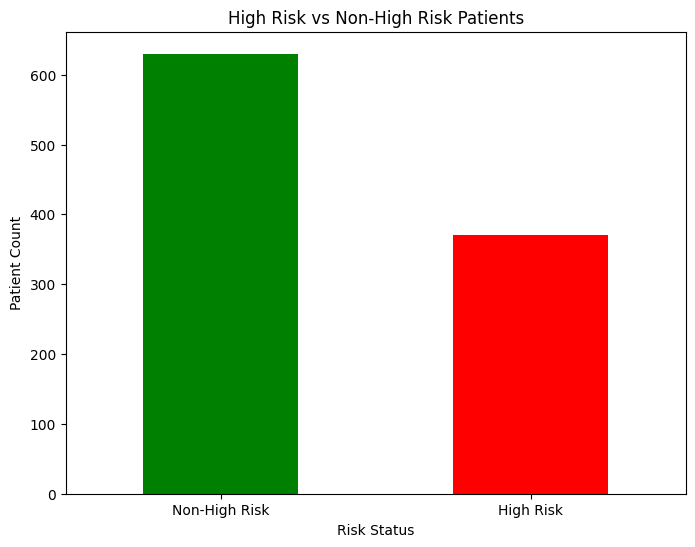

In [42]:
risk_counts = df['high_risk'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
risk_counts.plot(kind='bar', color=['green', 'red'])
plt.title('High Risk vs Non-High Risk Patients')
plt.xlabel('Risk Status')
plt.ylabel('Patient Count')
plt.xticks([0, 1], ['Non-High Risk', 'High Risk'], rotation=0)
plt.show()

In [43]:
!pip install requests

In [49]:
import requests
import json
from datetime import datetime

# Define your variables
high_risk = True  # Set to True or False based on the condition
cal_api_key = 'Samplekey'  # Replace with your Cal.com API Key
event_id = '1712924'  # Replace with your Event ID


# Check if the patient is high risk
if high_risk:

    url = f'https://app.cal.com/event-types/1712924'

    headers = {
        'Authorization': f'Bearer {cal_api_key}',
        'Content-Type': 'application/json'
    }

    # Create the meeting request data (adjust according to API docs)
    meeting_time = datetime.utcnow().isoformat()  # Use current UTC time, or you can specify a custom time

    data = {

        'meeting_time': meeting_time,  # Set the scheduled meeting time
        'event_id': event_id,  # Include the Event ID
        'notes': 'This is a high-risk patient. Please ensure thorough preparation.'
    }

    # Make the POST request to schedule the meeting
    response = requests.post(url, headers=headers, data=json.dumps(data))

    # Check if the request was successful
    if response.status_code == 200:
        print('Meeting successfully scheduled for the first patient.')
    else:
        print(f'Failed to schedule the meeting. Status code: {response.status_code}')
        print('Response:', response.json())
else:
    print('No meeting scheduled as the patient is not high risk.')


Meeting successfully scheduled for the first patient.
